## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, BatchNormalization, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

In [28]:
import os, sys

## Load MNIST Dataset

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 3s 0us/step


In [7]:
x_train.shape

(60000, 28, 28)

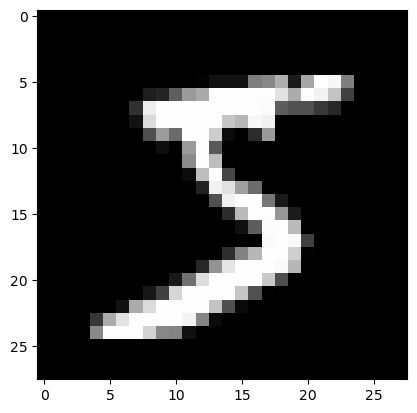

In [10]:
plt.imshow(x_train[0], cmap='gray')

### Normalisation

Values lie between -1 and +1

In [11]:
x_train = (x_train/255.0)*2 -1
x_test = (x_test/255.0)*2 -1

* The Dataset is already in the shape that is not acceptable to ANN and  so we need to reshape the data.
* We know that standard MNIST Dataset does not contain any null or missing values so no data preprocessing is required.

In [14]:
H = x_train.shape[1]            #Height
W = x_train.shape[2]            #Width

In [16]:
D = H * W                      # Dimension of an Image

In [30]:
x_train = x_train.reshape(-1, D)
x_test = x_test.reshape(-1, D)

### Latent Dimension

In [31]:
latent_dim = 100

## Create Generator Neural Network:

In [32]:
def create_generator(latent_dim):
    input_gen = Input(shape=(latent_dim,))
    output_gen = Dense(256, activation=LeakyReLU(alpha=0.2))(input_gen)
    output_gen = BatchNormalization(momentum=0.7)(output_gen)
    output_gen = Dense(512, activation=LeakyReLU(alpha=0.2))(output_gen)
    output_gen = BatchNormalization(momentum=0.7)(output_gen)
    output_gen = Dense(1024, activation=LeakyReLU(alpha=0.2))(output_gen)
    output_gen = BatchNormalization(momentum=0.7)(output_gen)
    output_gen = Dense(D, activation='tanh')(output_gen)
    
    model_gen = Model(input_gen, output_gen)
    return model_gen

## Create Discriminator Neural Network

In [33]:
def create_discriminator(image_size):
    input_dis = Input(shape=(image_size,))
    output_dis = Dense(512, activation=LeakyReLU(alpha=0.2))(input_dis)
    output_dis = Dense(256, activation=LeakyReLU(alpha=0.2))(output_dis)
    output_dis = Dense(1, activation='sigmoid')(output_dis)
    
    model_dis = Model(input_dis, output_dis)
    return model_dis

## Compile Discriminator Neural Network

In [34]:
discriminator = create_discriminator(D)
discriminator.compile(loss='binary_crossentropy',
                     optimizer= Adam(learning_rate=0.0002, beta_1=0.5),
                     metrics= ['accuracy'])

## Create and Compile Combined Network

In [35]:
generator = create_generator(latent_dim)

# To send noise as input to the generator neural network
noise = Input(shape=(latent_dim,))

# Generate Images
image = generator(noise)

# Get prediction from discriminator about these images
fake_pred = discriminator(image)

#To ensure that only the generator get trained
discriminator.trainable = False

combined_model = Model(noise, fake_pred)

# Compile the Combined Model
combined_model.compile(loss='binary_crossentropy',
                      optimizer= Adam(learning_rate=0.0002, beta_1=0.5))

### Model Configuration


In [36]:
batch = 32
epochs =10000

# Create an array of ones and zeros to use during training
d_ones = np.ones(batch)
d_zeros =np.zeros(batch) 

g_losses = []
d_losses = []

if not os.path.exists('MNIST_GAN_Images'):
    os.makedirs('MNIST_GAN_Images')

## See Sample Images

In [40]:
def sample_images(epoch):
    rows, cols =5,5
    noise = np.random.randn(rows*cols,latent_dim)
    imgs = generator.predict(noise)
    
    # rescale the image back to 0 and 1
    imgs = 0.5* imgs + 0.5
    
    fig, ax = plt.subplots(nrows= rows, ncols=cols)
    index=0
    for i in range(rows):
        for j in range(cols):
            ax[i,j].imshow(imgs[index].reshape(H, W), cmap='gray')
            ax[i,j].axis('off')
            index+=1
            
    fig.savefig("MNIST_GAN_Images/%d.png" % epoch)
    plt.close()
    

## Train Discriminator & Combined Model

In [41]:
for epoch in range(epochs):
    
    # Lets get random real images equal to the batch size
    real_images_dindex = np.random.randint(0, x_train.shape[0], batch)
    real_images_dis = x_train[real_images_dindex]
    
    #Lets get fake images through generator
    noise_dis = np.random.randn(batch, latent_dim)
    fake_images_dis = generator.predict(noise_dis)
    
    # Lets now train the discriminator
    real_dis_loss, real_dis_accuracy = discriminator.train_on_batch(real_images_dis, d_ones)
    fake_dis_loss, fake_dis_accuracy = discriminator.train_on_batch(fake_images_dis, d_zeros)
    avg_loss = 0.5*(real_dis_loss + fake_dis_loss)
    avg_acc =  0.5*(real_dis_accuracy + fake_dis_accuracy)
    d_losses.append(avg_loss)
    d_acc.append(avg_acc)
    
    # Now lets train the Generator.
    fake_images_gnoise = np.random.randn(batch, latent_dim)
    fake_gen_loss = combined_model.train_on_batch(fake_images_gnoise, d_ones)
    
    # Repeat Again
    fake_images_gnoise = np.random.randn(batch, latent_dim)
    fake_gen_loss = combined_model.train_on_batch(fake_images_gnoise, d_ones)
    g_losses.append(fake_gen_loss)
    
    
    if epoch % 100 ==0:
        print("Epoch :{}  d_loss:{}  g_loss:{} d_acc:{}".format(epoch+1,avg_loss, fake_gen_loss, avg_acc))
        
    if epoch % 200 ==0:
        sample_images(epoch)

1/1 [==============================] - 0s 32ms/step
Epoch :1  d_loss:0.40453846007585526  g_loss:0.5907037258148193 d_acc:0.671875
1/1 [==============================] - 0s 15ms/step
Epoch :101  d_loss:0.04281649552285671  g_loss:4.377983093261719 d_acc:0.984375
1/1 [==============================] - 0s 32ms/step
Epoch :201  d_loss:0.5884116888046265  g_loss:1.1719557046890259 d_acc:0.671875
1/1 [==============================] - 0s 32ms/step
Epoch :301  d_loss:0.649010419845581  g_loss:0.6281760931015015 d_acc:0.484375
1/1 [==============================] - 0s 16ms/step
Epoch :401  d_loss:0.6836652457714081  g_loss:0.6387172937393188 d_acc:0.484375
1/1 [==============================] - 0s 32ms/step
Epoch :501  d_loss:0.6879468858242035  g_loss:0.6379428505897522 d_acc:0.46875
1/1 [==============================] - 0s 16ms/step
Epoch :601  d_loss:0.6519136130809784  g_loss:0.6990656852722168 d_acc:0.703125
1/1 [==============================] - 0s 32ms/step
Epoch :701  d_loss:0.679872

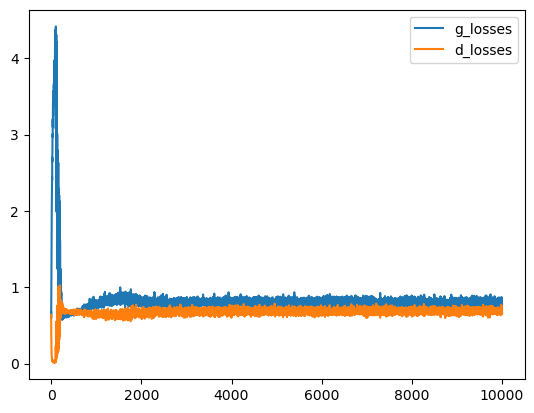

In [42]:
plt.plot(g_losses, label='g_losses')
plt.plot(d_losses, label='d_losses')
plt.legend()